## Simple audio recognition: Recognizing keywords

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic automatic speech recognition (ASR) model for recognizing ten different words. You will use a portion of the Speech Commands dataset (Warden, 2018), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".



## Setup

Import necessary modules and dependencies. You'll be using tf.keras.utils.audio_dataset_from_directory (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of .wav files. You'll also need seaborn for visualization in this tutorial.


In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The original dataset consists of over 105,000 audio files in the WAV (Waveform) audio file format of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the mini_speech_commands.zip file containing the smaller Speech Commands datasets with tf.keras.utils.get_file:

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


The dataset's audio clips are stored in eight folders corresponding to each speech command: no, yes, down, go, left, up, right, and stop:

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'left' 'yes' 'no' 'stop' 'down' 'go' 'up']


Divided into directories this way, you can easily load the data using keras.utils.audio_dataset_from_directory.

The audio clips are 1 second or less at 16kHz. The output_sequence_length=16000 pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction.

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [9]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

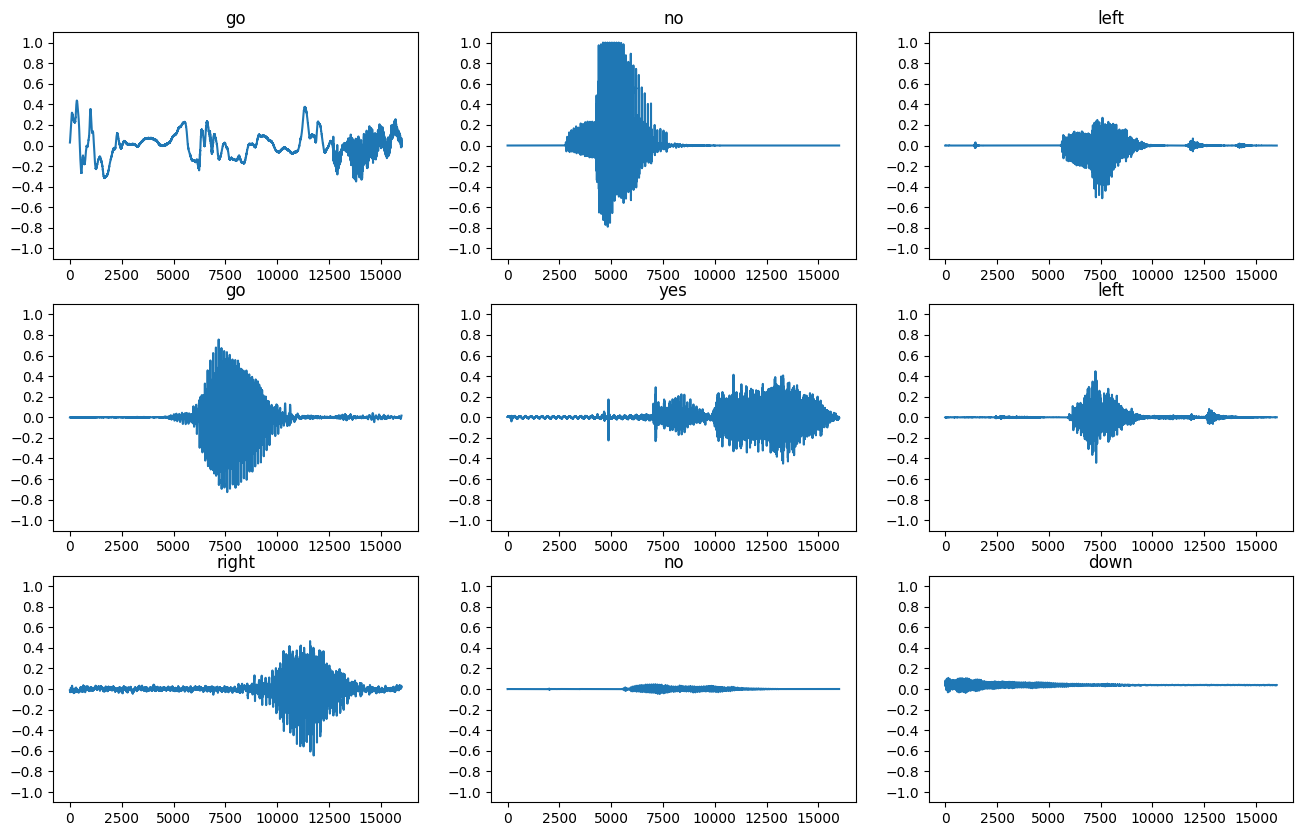

In [10]:
# Let's plot a few audio waveforms:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

In [11]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [12]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [18]:
# Now, define a function for displaying a spectrogram
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

  """
  Plot the example's waveform over time
  and the corresponding spectrogram (frequencies over time):
  """

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, np.array(waveform))
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 16000])

  plot_spectrogram(np.array(spectrogram), axes[1])
  axes[1].set_title('Spectrogram')
  plt.suptitle(label.title())
  plt.show()

In [19]:
# Now, create spectrogramn datasets from the audio datasets
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [15]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

<ipython-input-18-048b128d0c12>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, figsize=(12, 8))


RecursionError: ignored

Error in callback <function _draw_all_if_interactive at 0x7f632c8f9630> (for post_execute):


KeyboardInterrupt: ignored

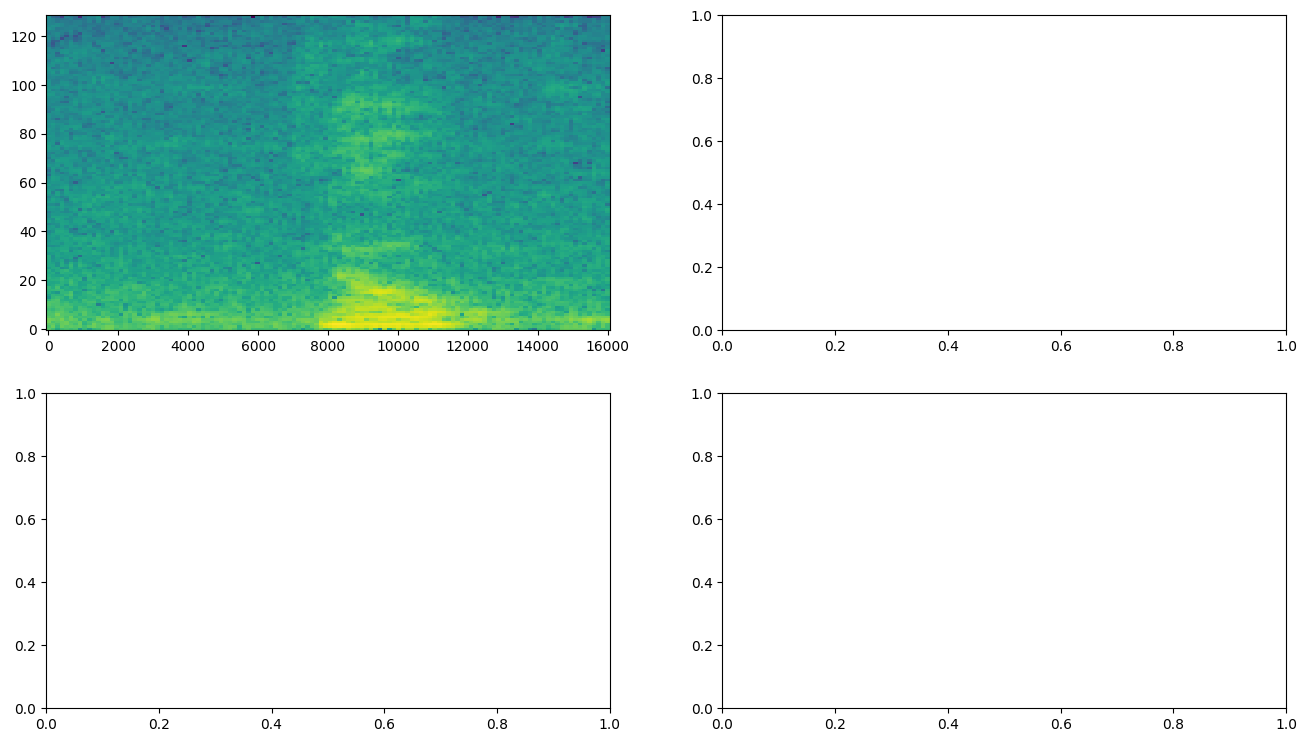

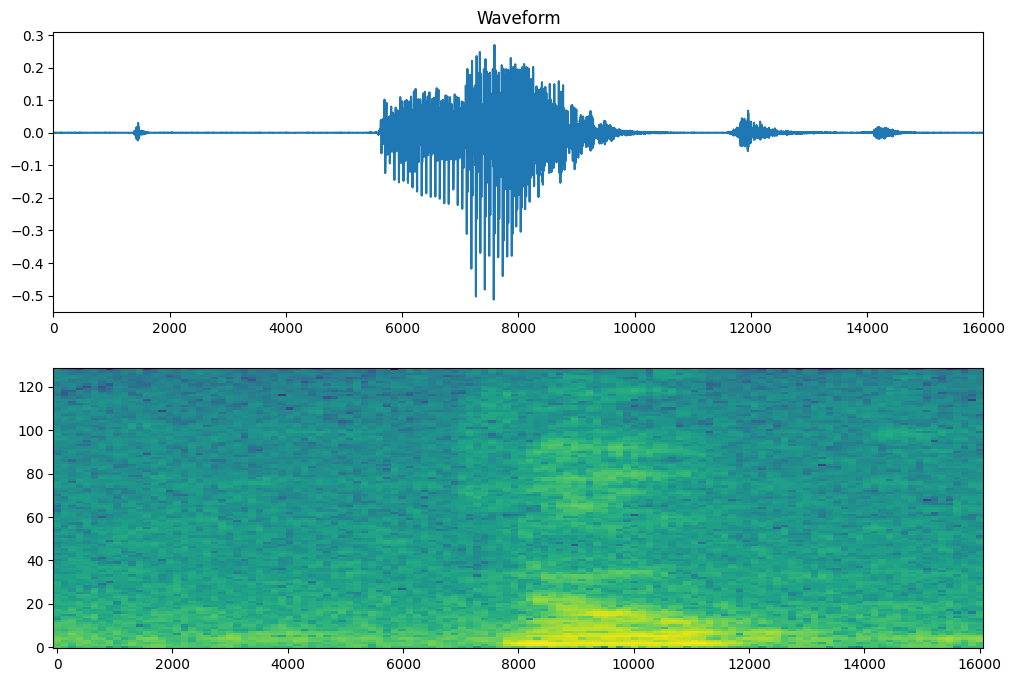

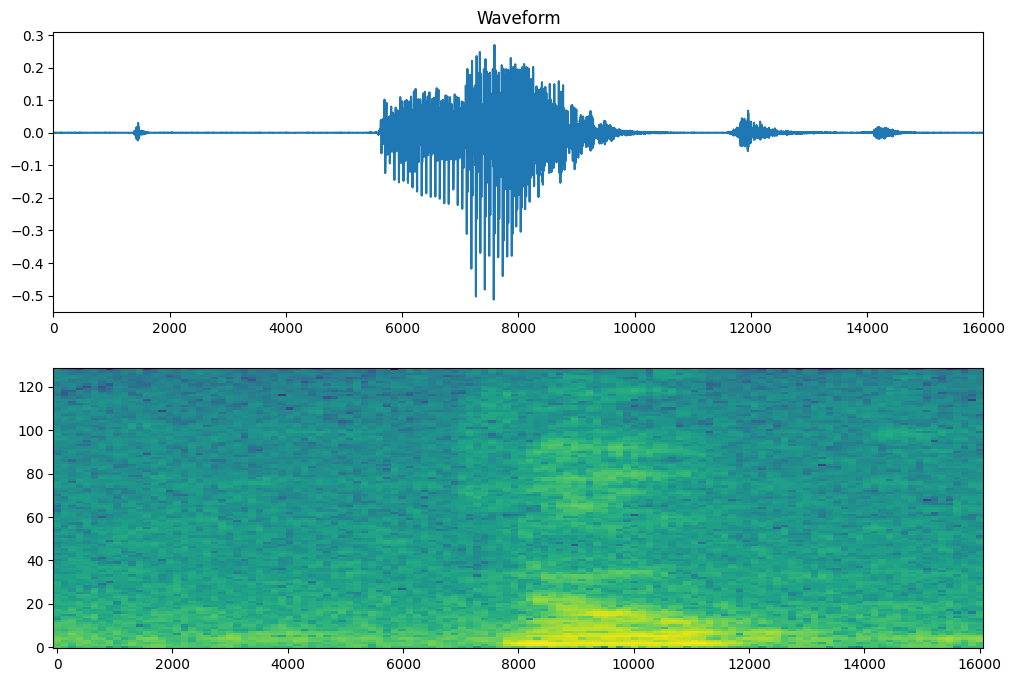

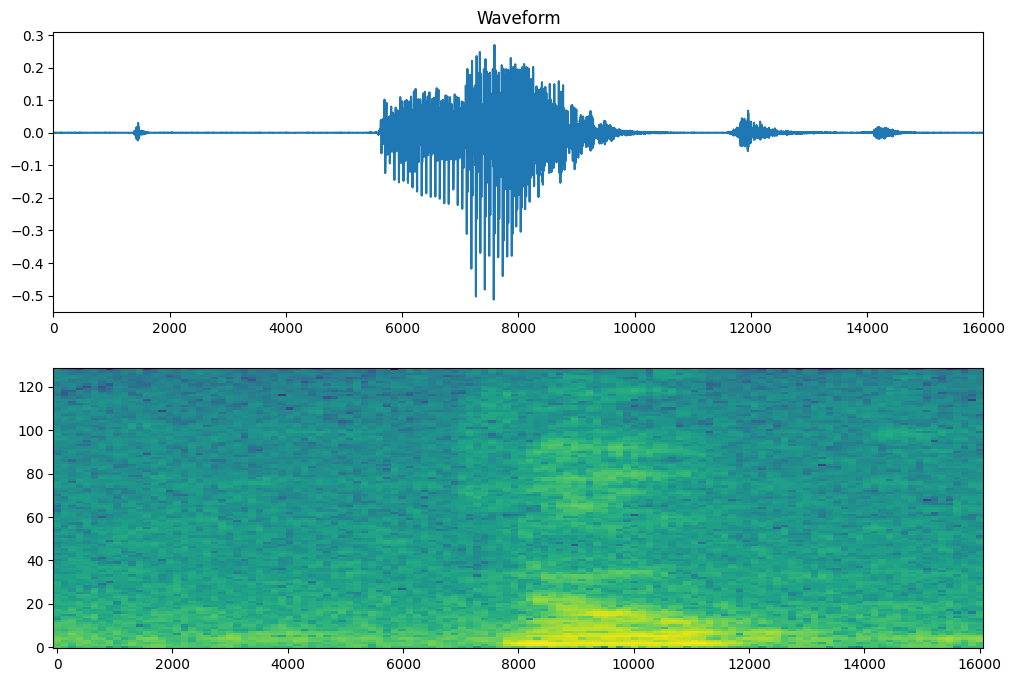

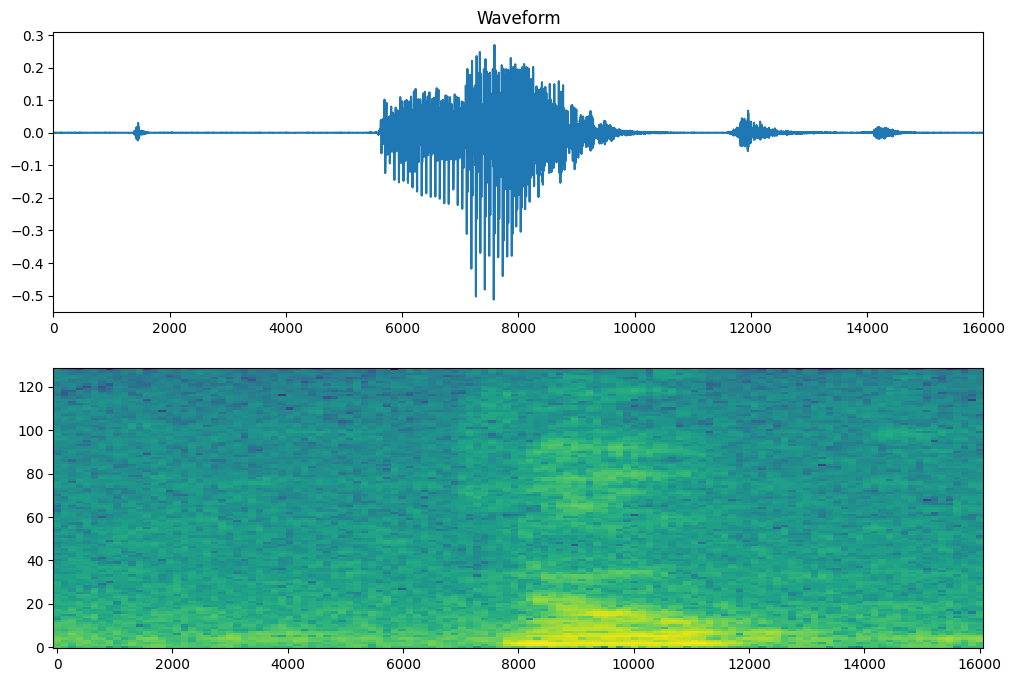

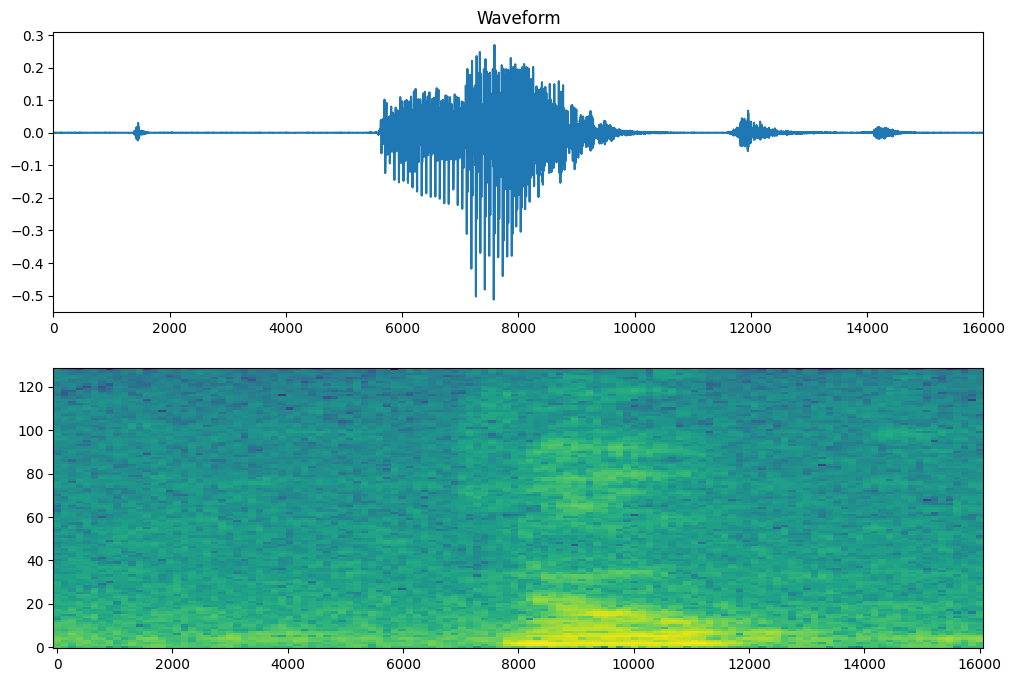

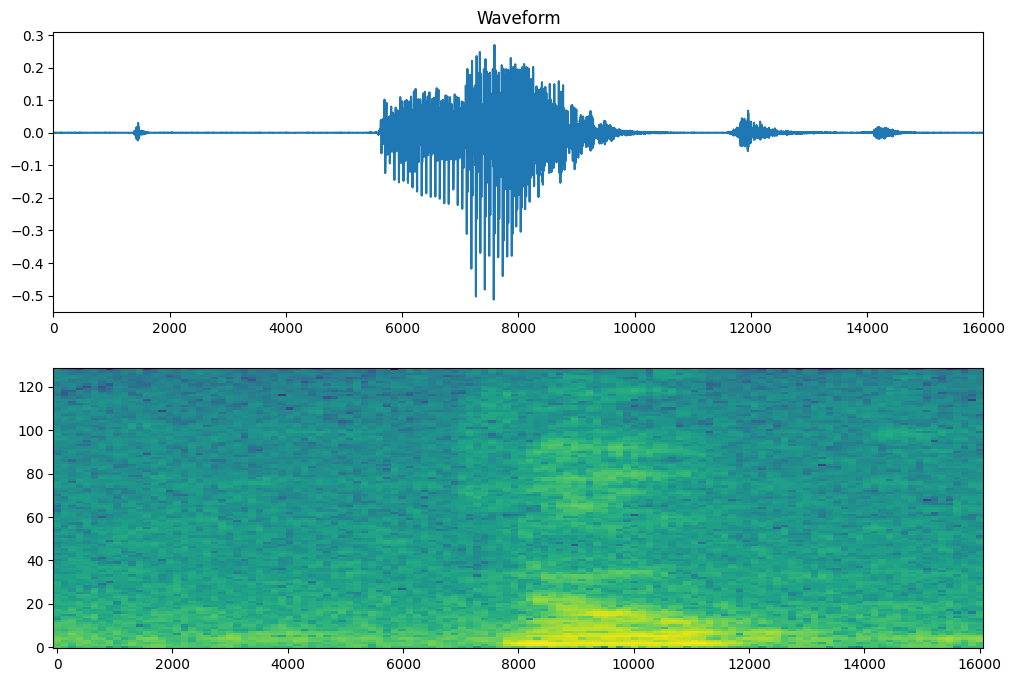

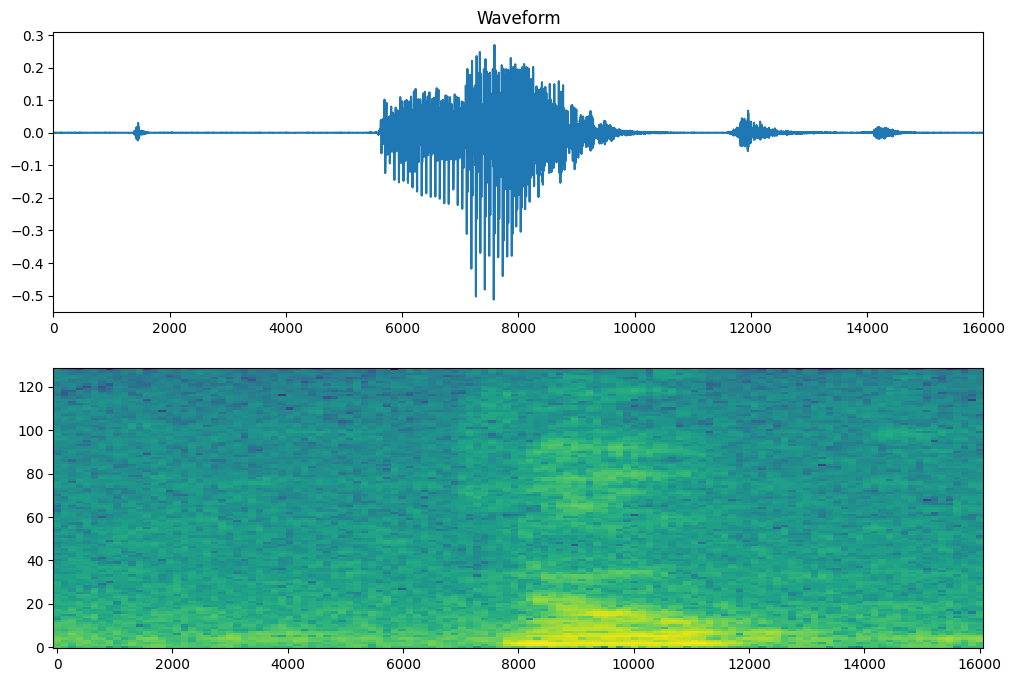

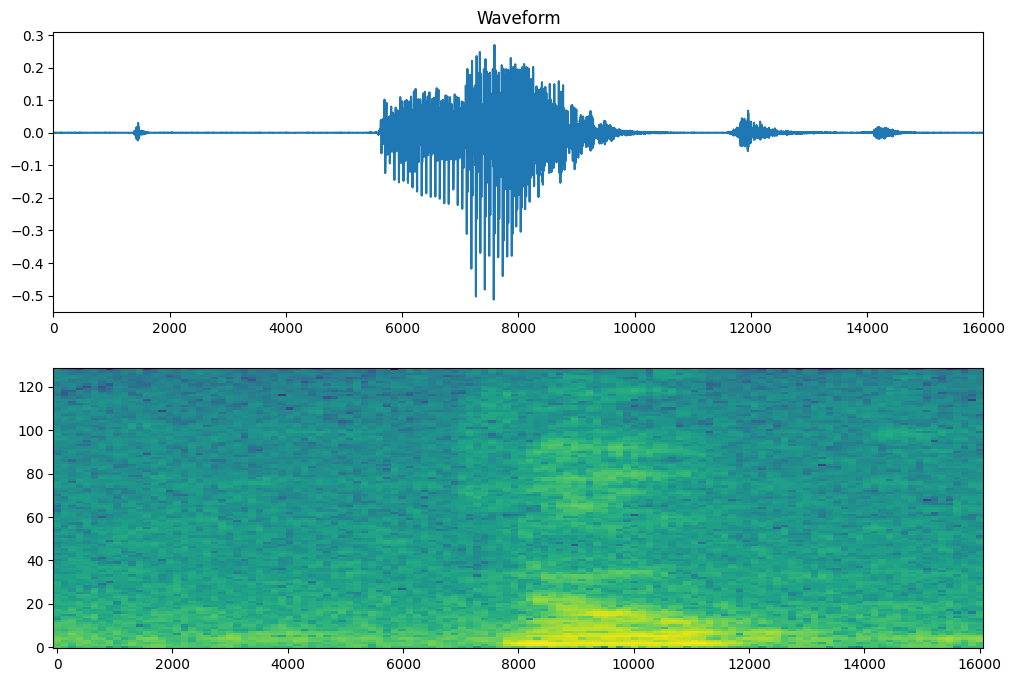

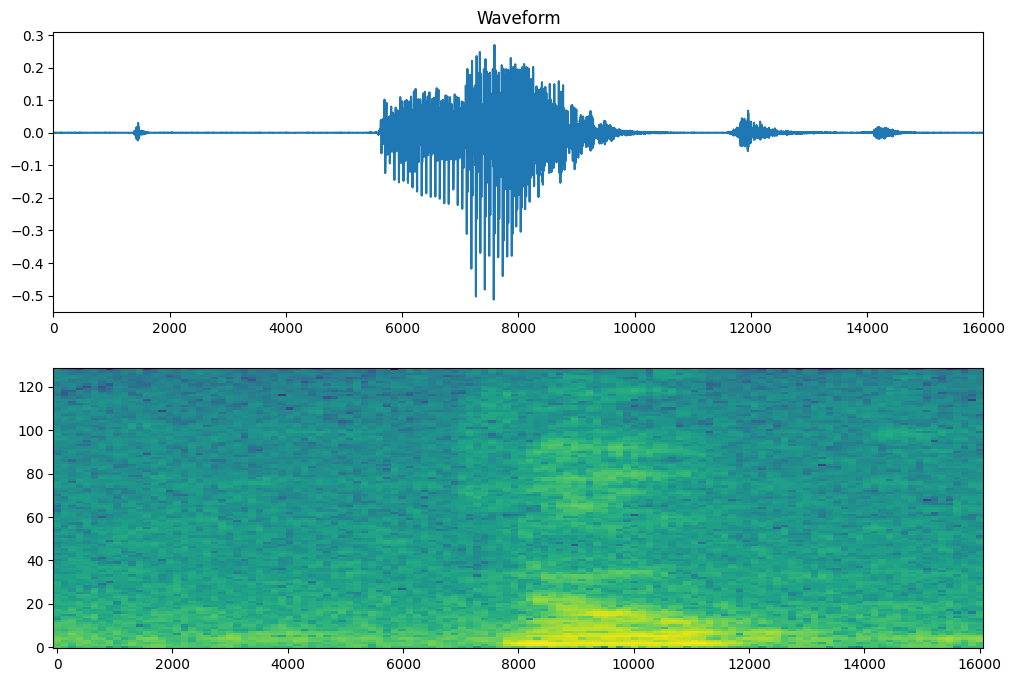

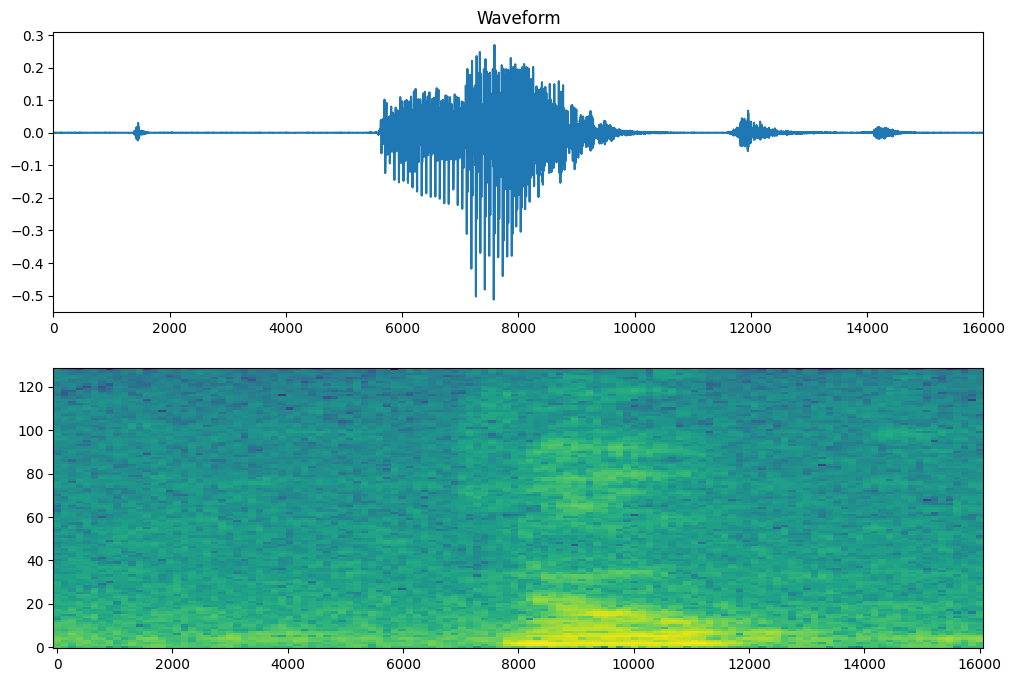

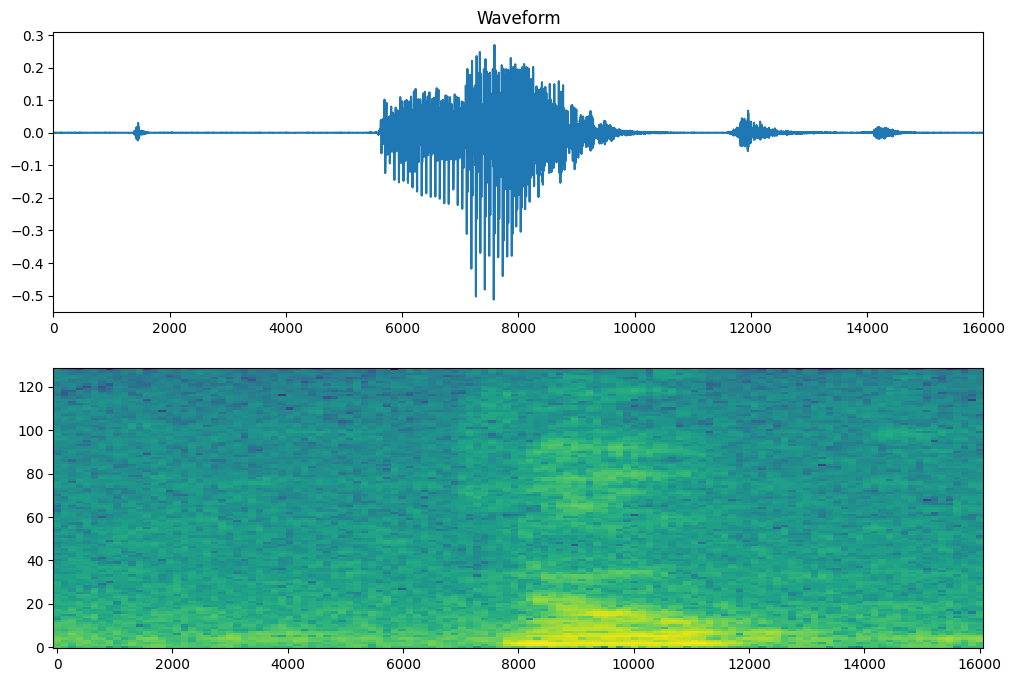

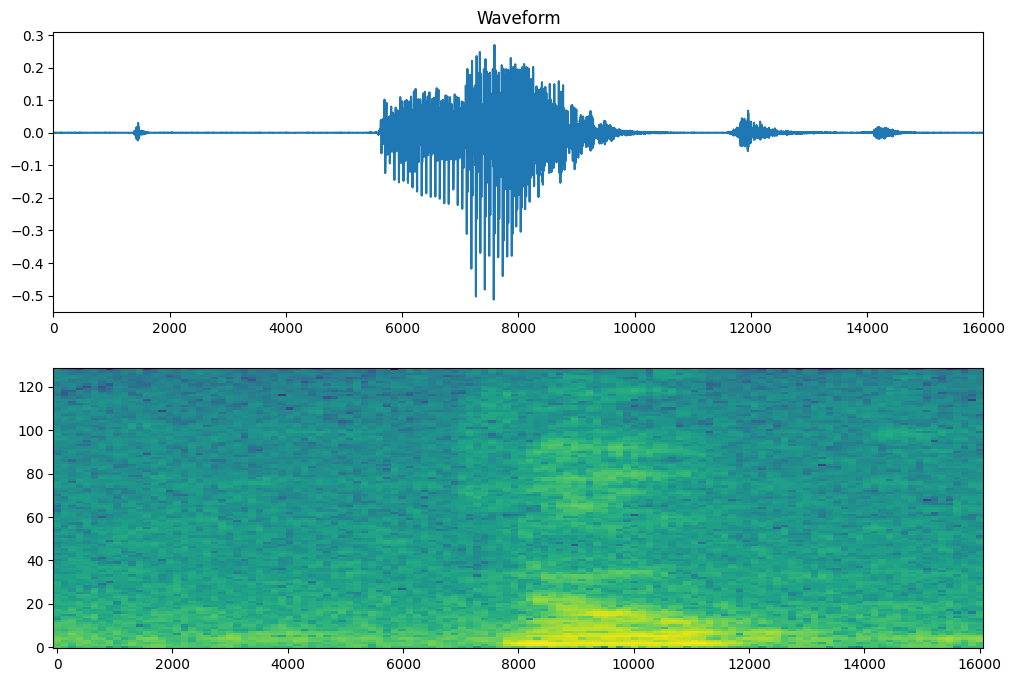

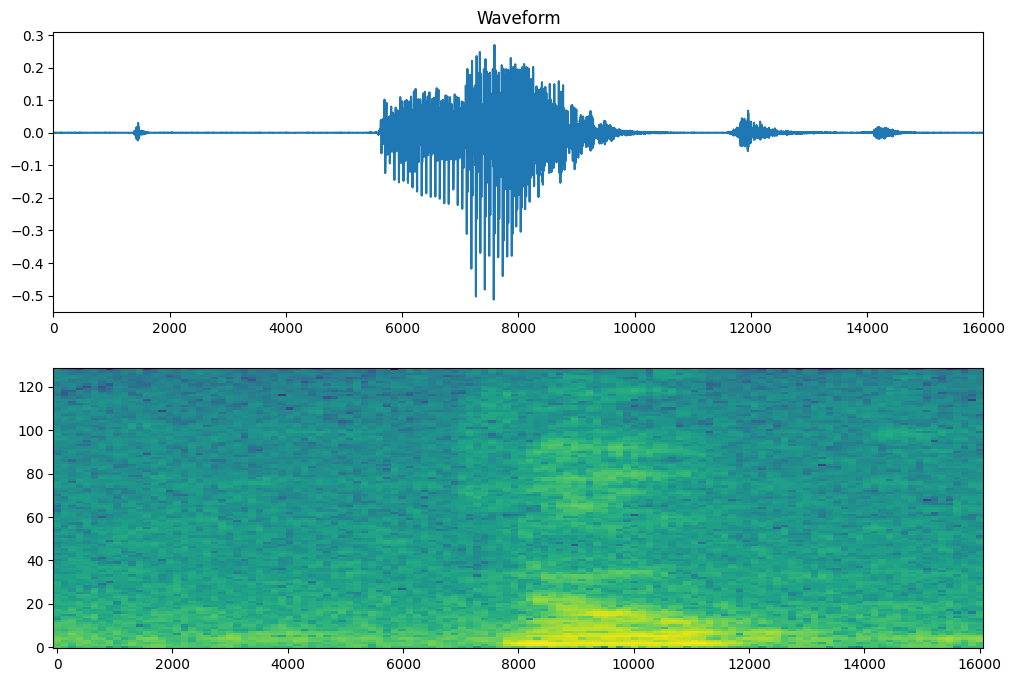

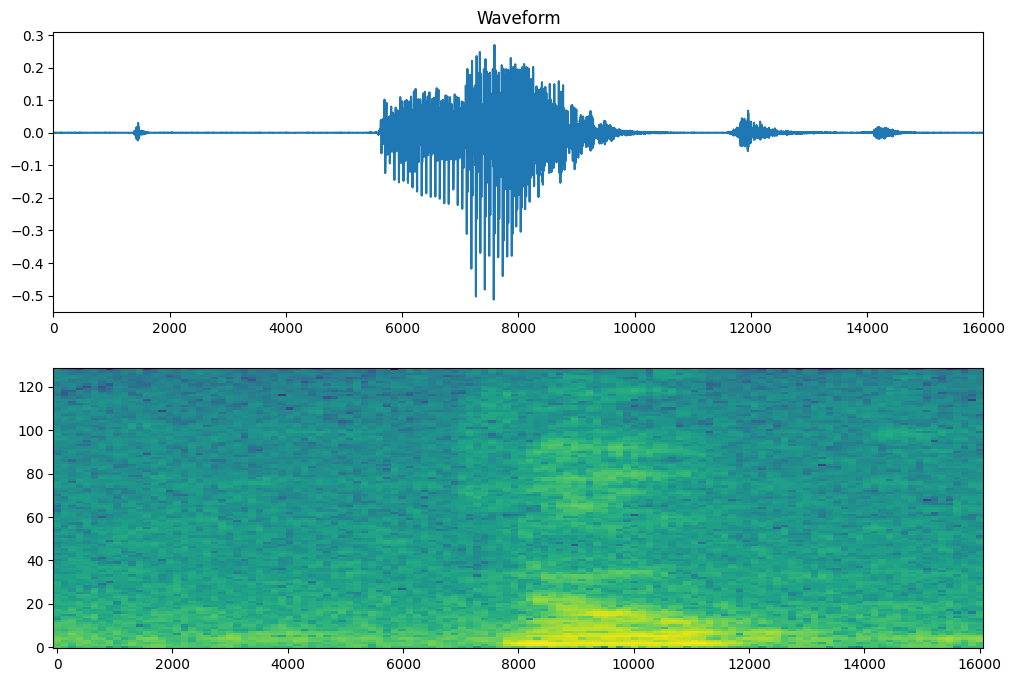

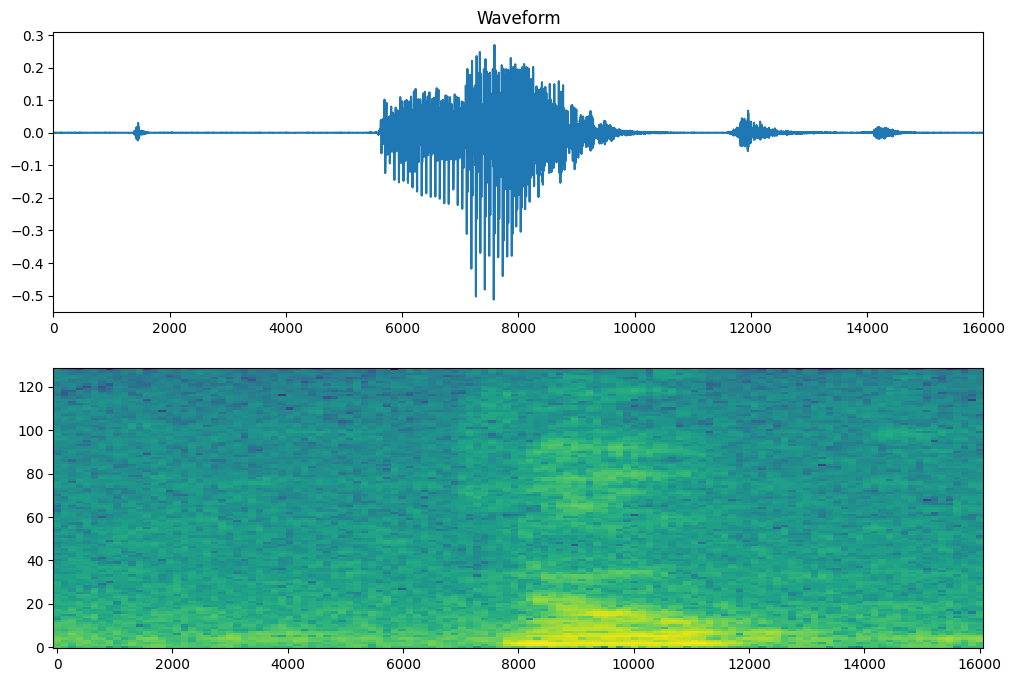

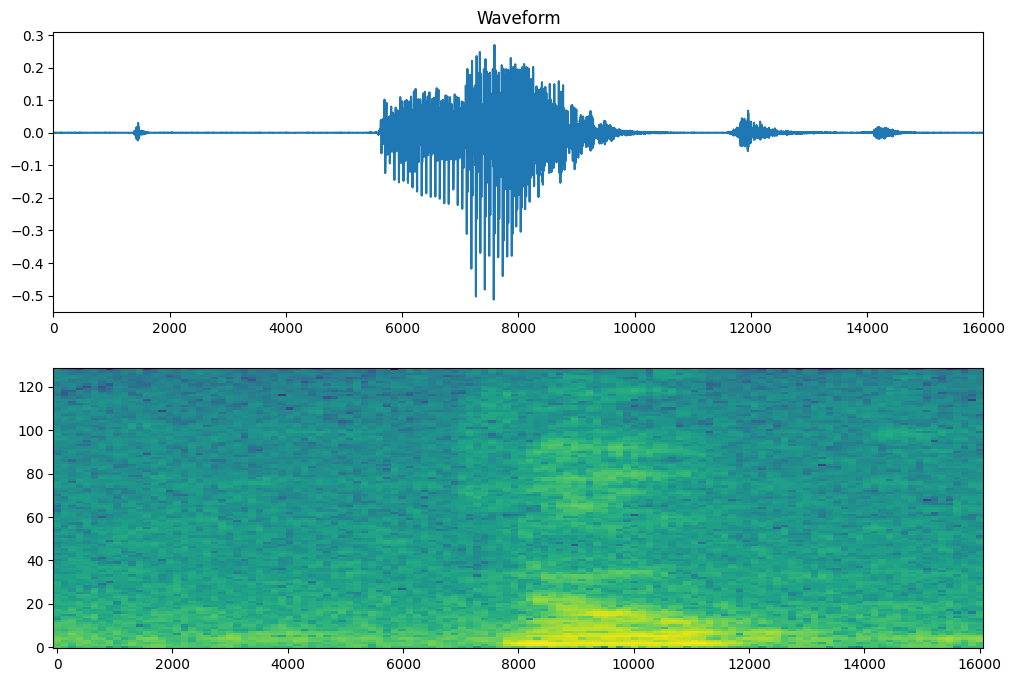

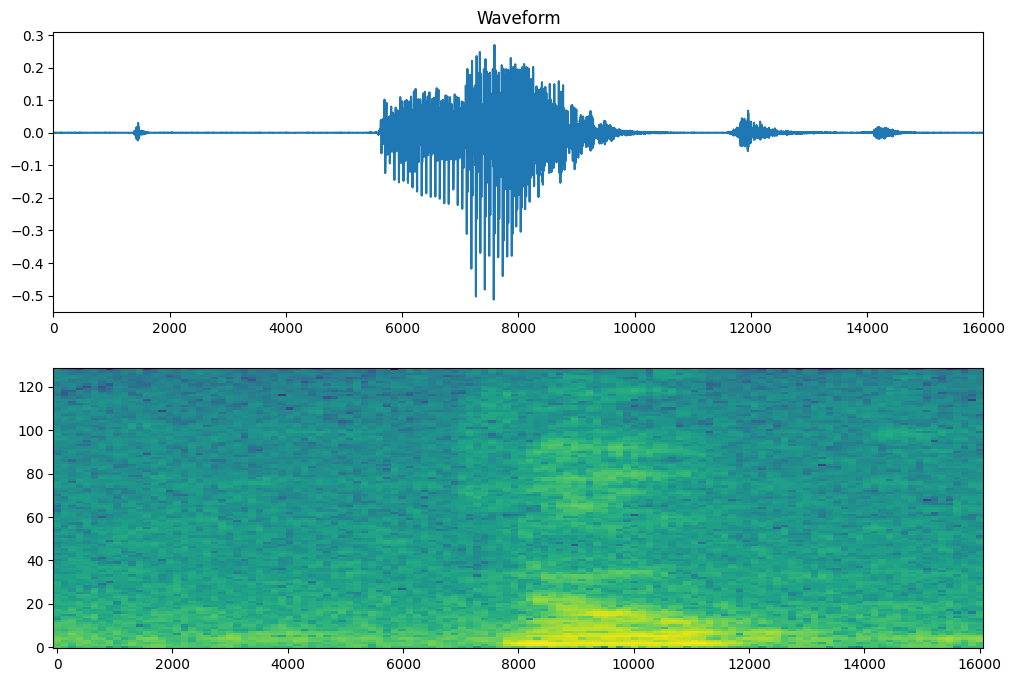

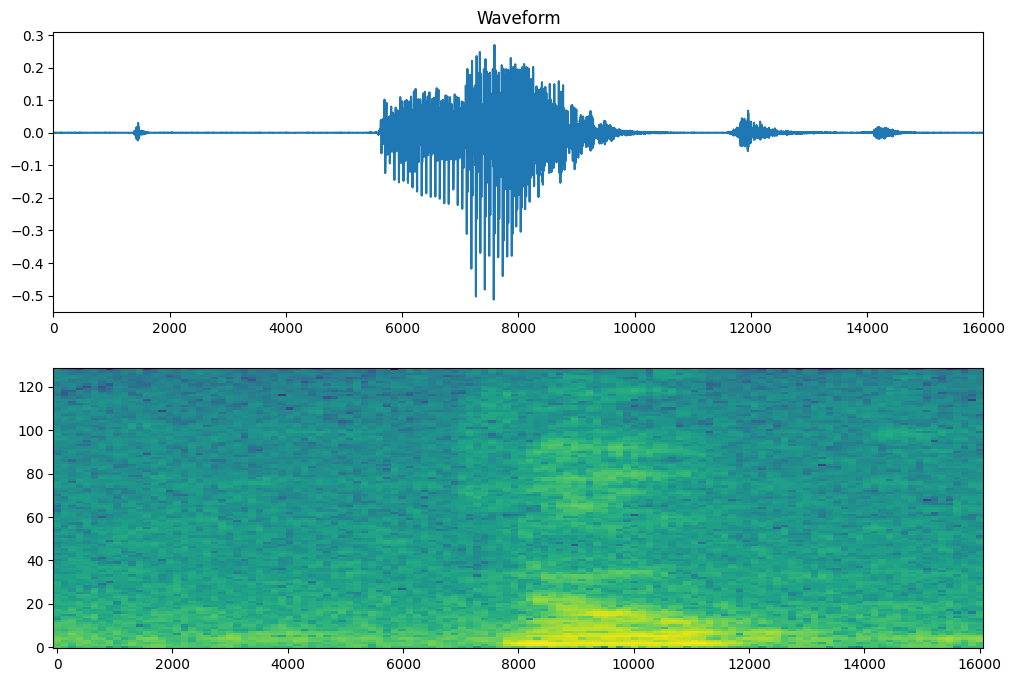

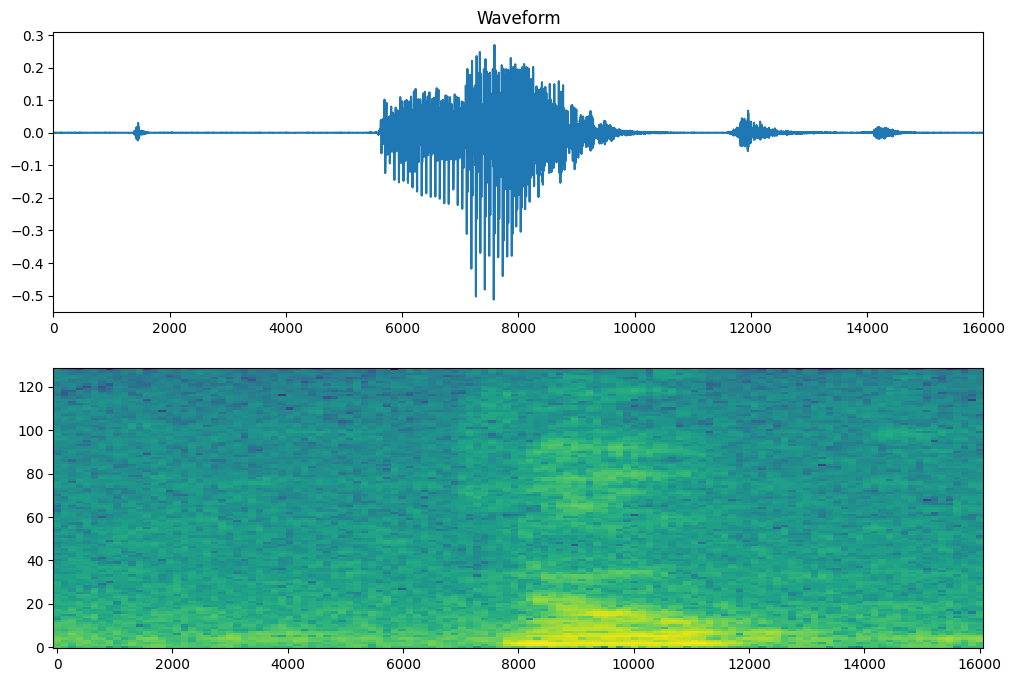

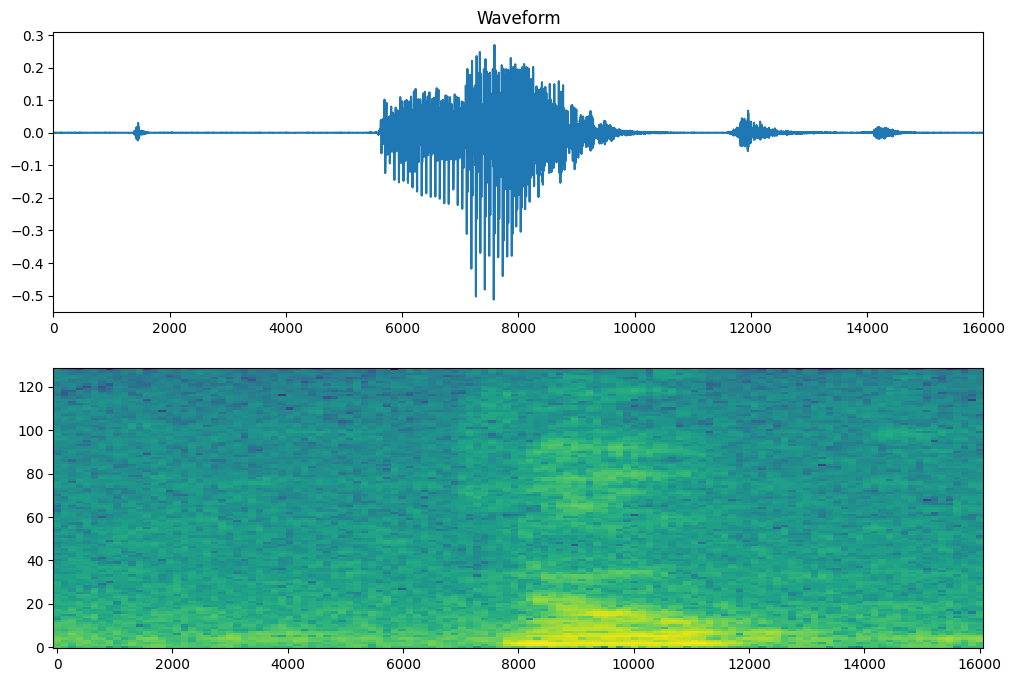

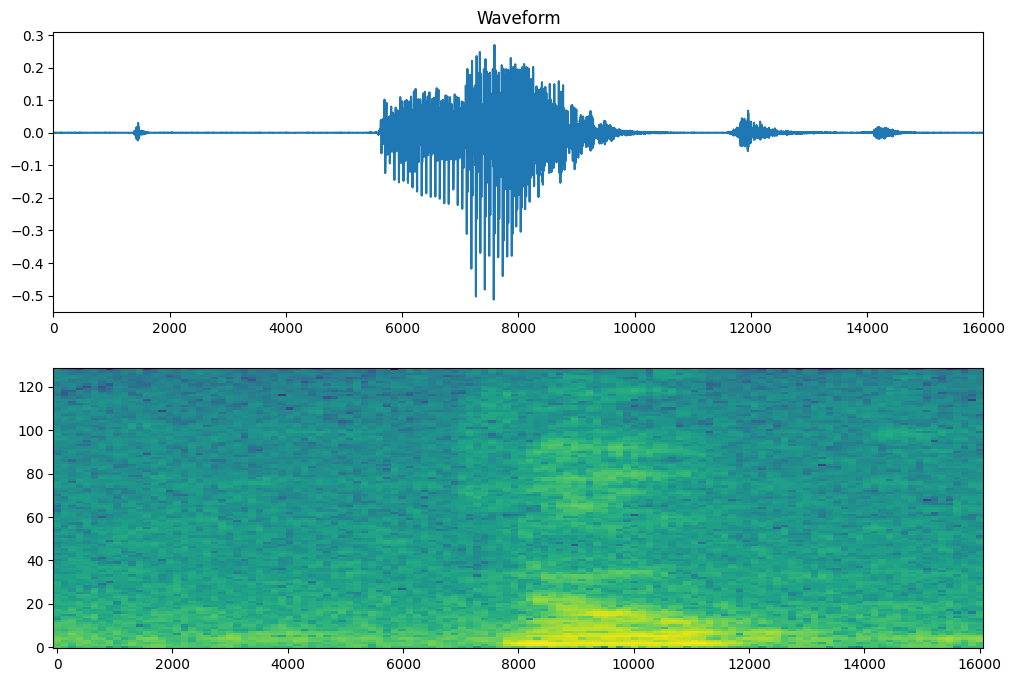

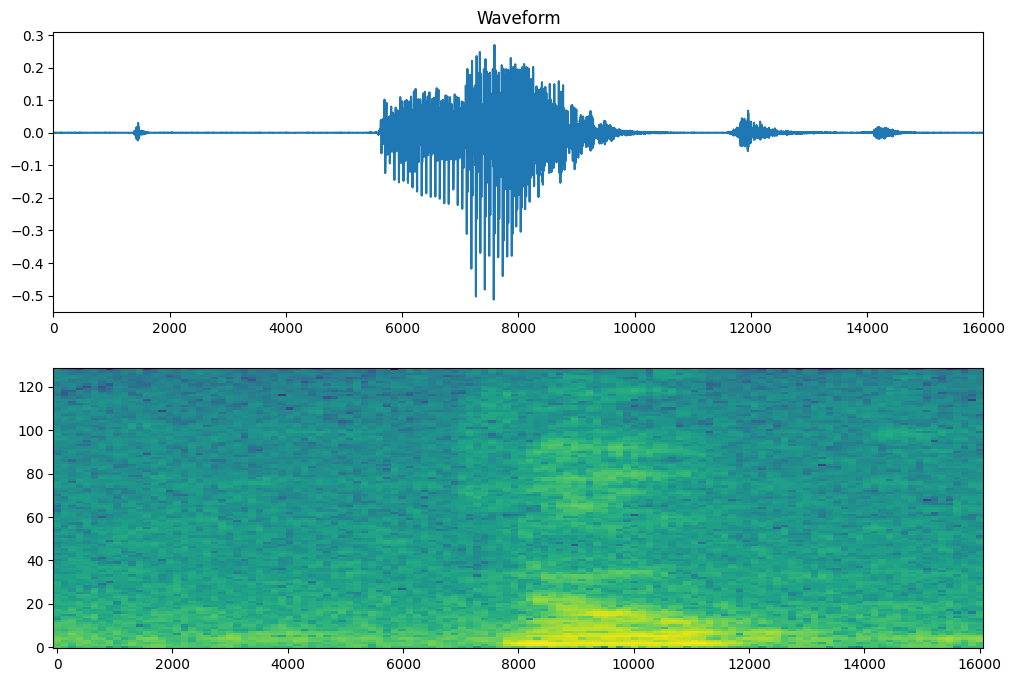

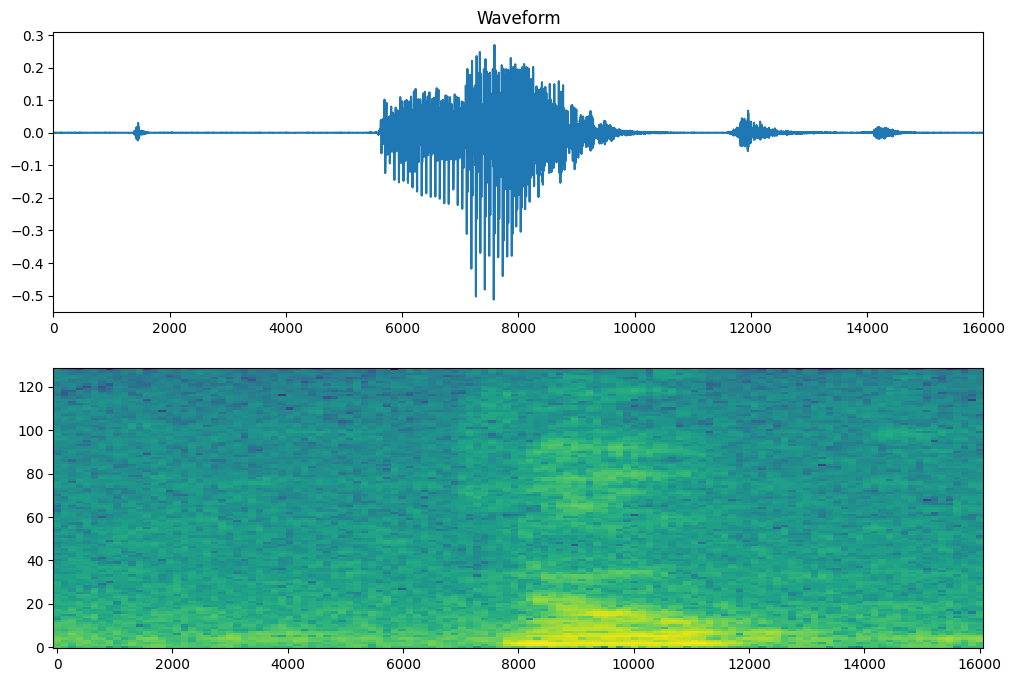

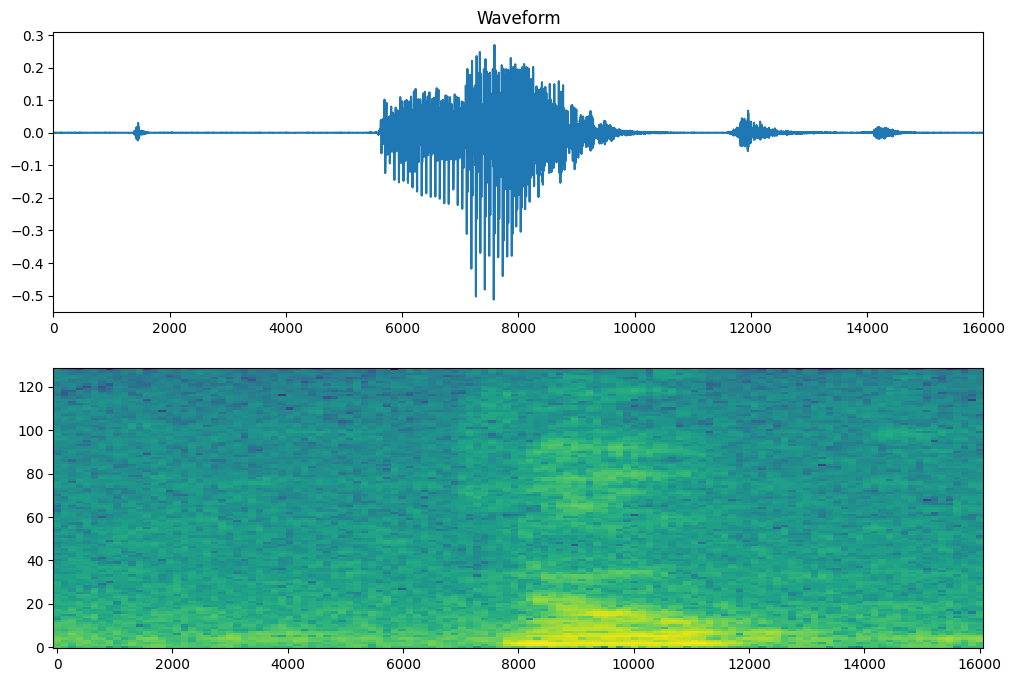

Error in callback <function flush_figures at 0x7f632c8f88b0> (for post_execute):


KeyboardInterrupt: ignored

In [23]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.array(example_spectrograms[i]), ax)
    ax.set_title(label_names[np.array(example_spect_labels[i])])

plt.show()

## Build and Train the model

Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [24]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your tf.keras.Sequential model will use the following Keras preprocessing layers:

tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation)

In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [27]:
# Train the model over 10 epochs for demonstration purposes:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 16s 41ms/step - loss: 1.7471 - accuracy: 0.3677 - val_loss: 1.3140 - val_accuracy: 0.5898
Epoch 2/10
100/100 [==============================] - 1s 8ms/step - loss: 1.1781 - accuracy: 0.5778 - val_loss: 0.9169 - val_accuracy: 0.7305
Epoch 3/10
100/100 [==============================] - 1s 8ms/step - loss: 0.8945 - accuracy: 0.6816 - val_loss: 0.7499 - val_accuracy: 0.7839
Epoch 4/10
100/100 [==============================] - 1s 8ms/step - loss: 0.7191 - accuracy: 0.7422 - val_loss: 0.6581 - val_accuracy: 0.7786
Epoch 5/10
100/100 [==============================] - 1s 8ms/step - loss: 0.6214 - accuracy: 0.7808 - val_loss: 0.5822 - val_accuracy: 0.8255
Epoch 6/10
100/100 [==============================] - 1s 9ms/step - loss: 0.5326 - accuracy: 0.8128 - val_loss: 0.5532 - val_accuracy: 0.8333
Epoch 7/10
100/100 [==============================] - 1s 8ms/step - loss: 0.4743 - accuracy: 0.8325 - val_loss: 0.5248 - val_accuracy: 0.8346
Epoc

Text(0, 0.5, 'Accuracy [%]')

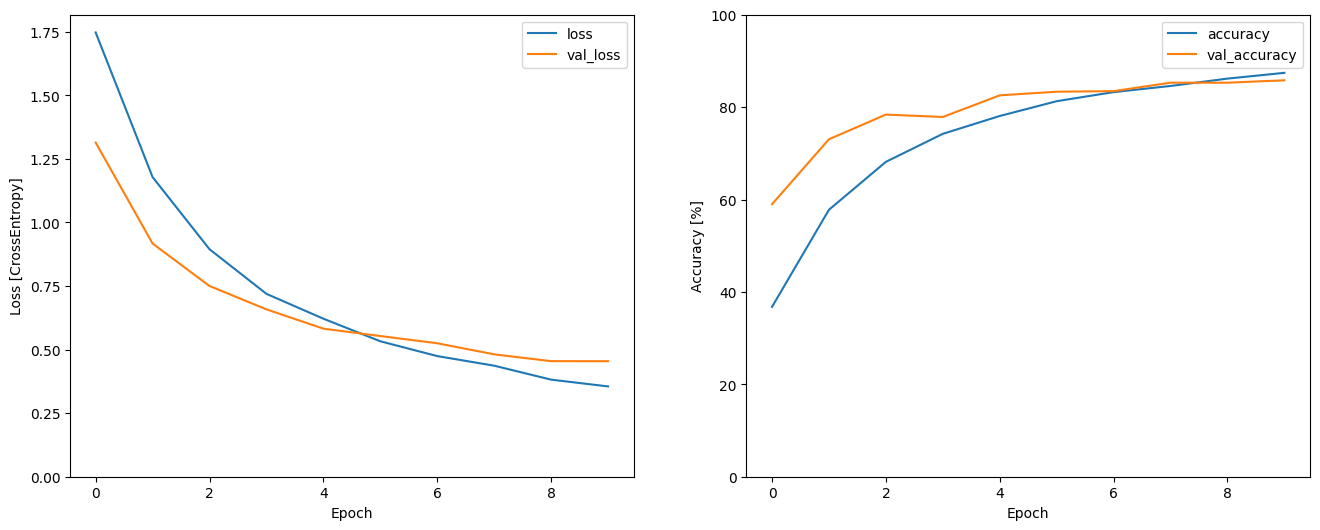

In [28]:
#Let's plot the training and validation loss curves to check how your model has improved during training:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [29]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 2s 163ms/step - loss: 0.4607 - accuracy: 0.8317


{'loss': 0.4607028663158417, 'accuracy': 0.8317307829856873}

## Display a confusion matrix

In [30]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 4ms/step


In [31]:
y_pred = tf.argmax(y_pred, axis=1)

In [32]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

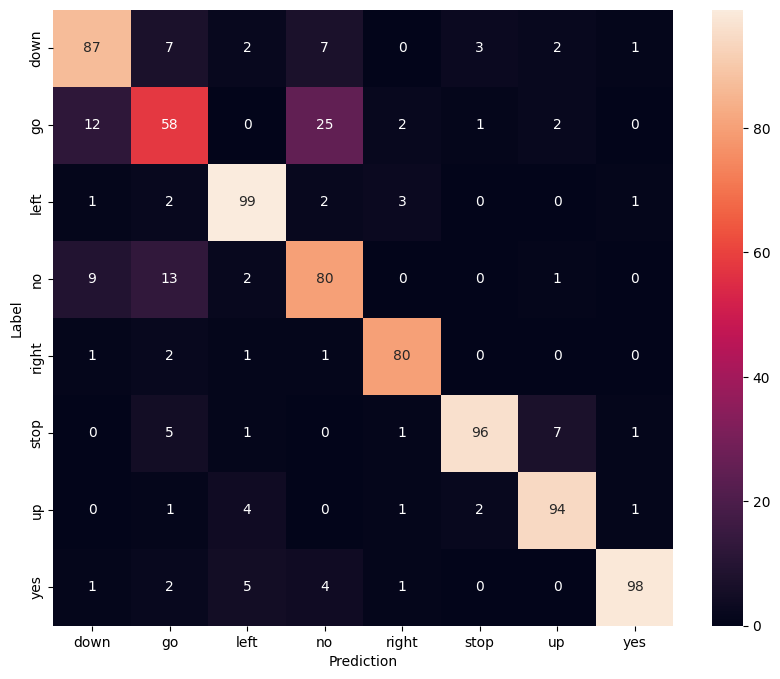

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

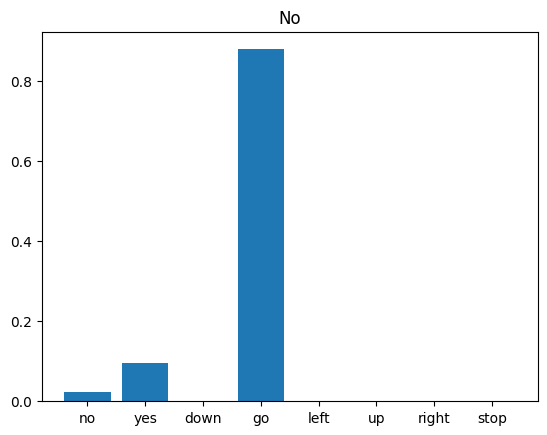

In [35]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [36]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [38]:
# Test run the "export" model:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.5349792,  1.950876 , -2.14197  ,  4.180332 , -3.839285 ,
         -3.5377307, -3.3253455, -2.178174 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [39]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.5349792,  1.950876 , -2.14197  ,  4.180332 , -3.839285 ,
         -3.5377307, -3.3253455, -2.178174 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>}

In [40]:
# save the model google drive
model.save("/content/drive/MyDrive/Saved_TensorFlow_Models/recognize_keywords")